# The CTRM data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

SEED = 42
np.random.seed(SEED)

## Looking at the CTRM files

We will start by looking at the CTRM geophone data we have for now

In [20]:
a = np.load("../LB_28ent.npy")
a.shape

(2558430, 5)

In [21]:
a[:, 3]

array([151., 152., 153., ..., 541., 542., 543.], dtype=float32)

In [22]:
b = a[a[:, 3] == 151.0]
b.shape

(6510, 5)

$a$ encode a box as $(x, y, z, t, semblance)$ coordinates

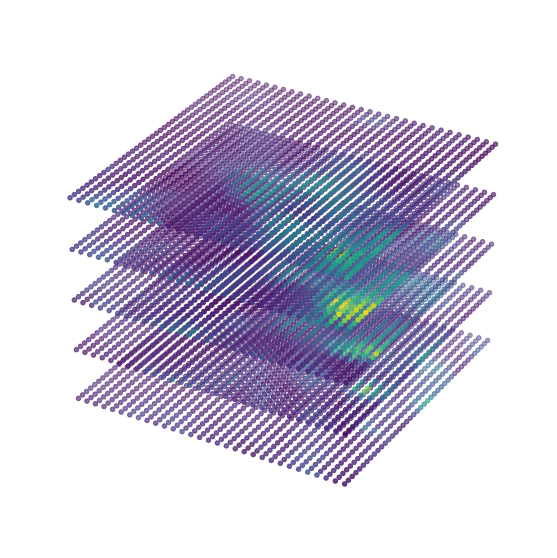

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.scatter(b[:, 0], b[:, 1], b[:, 2], c=b[:, 4])

plt.axis('off')
plt.show()

The data is stored as a cloud of voxels representation, but most machine learning models expect it to be organized in a matrix representation.

We will transform the data to a numpy array in the shape: $(i_{batch}, t, z, x, y)$ (we'll use the z, x, y representation because it's the representation used in the skimage library, and because it fits the large layer difference observed at the image above)

In [ ]:
############## Turn cloud of voxels to matrix data ##################







## Fabricated data

In case we don't have real, or synthetic data available, we can use the following code to generate fabricated data for basic testing (model input/ output layer fitting):

In [5]:
# data_fab = np.random.normal(0, 1, size=(8, 100, 35, 70, 70))
# g = lambda x, x_max: (x - (0.5 * x_max)) ** 2
# f_mat = lambda b, t, z, x, y, zm, xm, ym : (b + 1) * (g(x, xm) + g(y, ym) + g(z, zm) + (t**2) + 1)

In [6]:
# xm = data_fab.shape[3]
# ym = data_fab.shape[4]
# zm = data_fab.shape[2]
# data_fab_noise = data_fab
# for ib in tqdm((range(data_fab.shape[0]))):
#     for it in range(data_fab.shape[1]):
#         for ix in range(xm):
#             for iy in range(ym):
#                 for iz in range(zm):
#                     data_fab[ib, it, iz, ix, iy] = f_mat(ib, it, iz, ix, iy, zm, xm, ym)
# data_fab = (data_fab / data_fab.max()) + (0.3 * data_fab_noise)
# del data_fab_noise

100%|██████████| 8/8 [01:46<00:00, 13.36s/it]


## Preprocessing

Before we can proceed with this input layer, we have to standardize the size of our data, since not all of our images match this input shape.

In [7]:
import cv2
import skimage
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

Let's have a look at a snapshot of one of our frames to have a feel at the data we fabricated

In [8]:
def flatten_matrix(mat):
    """
    flatten a matrix by returning a value, index pair represantation
    :param mat: a numpy matrix to flatten
    :return: a list of form: val, i_0, i_1, ...
    """
    n_dim = len(mat.shape)
    s = mat.size
    
    v_ranges = []
    for d in range(n_dim):
        v_ranges.append(np.arange(mat.shape[d]))
        
    indexes = np.meshgrid(*v_ranges)
    res = [mat.ravel()]
    for ran in indexes:
        res.append(ran.ravel())
        
    for i, vec in enumerate(res):
        assert vec.size == s , f"dim mismatch, index num {i} is of size {vec.size} and not {s}"
    return res

# from mpl_toolkits.mplot3d import Axes3D
def plot_a_3D_frame(mat, b, t, figsize=(10, 10)):
    """
    plot a 3D frame from a batch file of 3D movies
    :param mat: the input matrix
    :param b: batch number
    :param t: time index
    :param figsize: the size of the plot
    :return: None
    """
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')

    data_cur = mat[b, t, :, :, :]
    c, iz, ix, iy = flatten_matrix(data_cur)
    ax.scatter(ix, iy, iz ,c=c)

    plt.axis('off')
    plt.show()

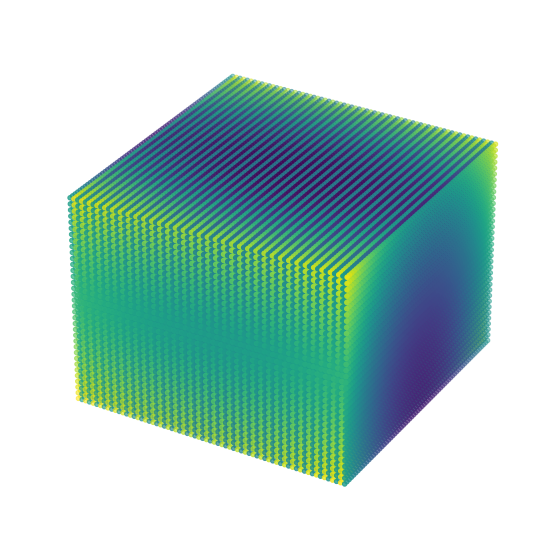

In [9]:
plot_a_3D_frame(data_fab, 0, 0)

Even at this size this is too large, and in real world conditions we can't expect for all of our input data to be server at exactly the right dimensions. We will fit all of our images to a standard size of $(x, y, z) = (64, 64, 32)$, but we will not touch the time dimension for now, since the time can remain variable, and we want to be able to predict on differing time scales.

We will define a function to resize the the image to any standard size:

In [10]:
from scipy.ndimage import zoom

def multD_resize(data, v_size, order=3, mode='constant'):
    """
    takes any numpy array, and zooms in or out as specified.
    can effect different dimensions differently.
    * we're using the zoom function from the scipy.ndimage library. It can be substituted 
    with the geometric_transform function from the same function, 
    :param data: the input, a numpy array
    :param v_size: a vector describing how to scale each of the of the dimensions. 
    - if a value for a dimension is a float, it will shrink or enlarge it by factoring by it 
    (for example, to double the number of pixels, pass 2.0f)
    - if a value for a dimension is an int, it will be the size of the new dimension
    - if a value of a dimention is None, it will remain as it is (same as passing 1)
    :param order: the order of the spline interpolation used to find the new data
    :param mode: {‘reflect’, ‘grid-mirror’, ‘constant’, ‘grid-constant’, ‘nearest’, ‘mirror’, 
    ‘grid-wrap’, ‘wrap’} 
    the method used to determine how to extend the new array beyond its original boundries.
    the default is 'constant'.
    :return: the resized data as a numpy array
    """
    v_fsize = v_size
    v_outp_s = list(data.shape)
    for i, s in enumerate(v_fsize):
        if s is None:
            # we want to ignore this dimension in our calculations
            v_fsize[i] = 1
        elif type(s) is int:
            # we want the new dimension to be of this size exactly
            v_outp_s[i] = s
            v_fsize[i] = s / data.shape[i]
        else:
            # we're assuming s is a float, 
            # and by passing a None, we're telling that we don't care about the exact new size
            v_outp_s[i] = None
    outp = zoom(data, v_fsize, order=order, mode=mode)
    
    for i, d in enumerate(v_outp_s):
        if d is not None:
            assert outp.shape[i] == d, f"the size of dim number {i+1} is {d}, expected {outp.shape[i]}"
    
    return outp

We will apply the transformation on our data:

In [11]:
x = multD_resize(data_fab, np.array([None, None, 32, 64, 64]))
x.shape

(8, 100, 32, 64, 64)

And let's check again how it look:

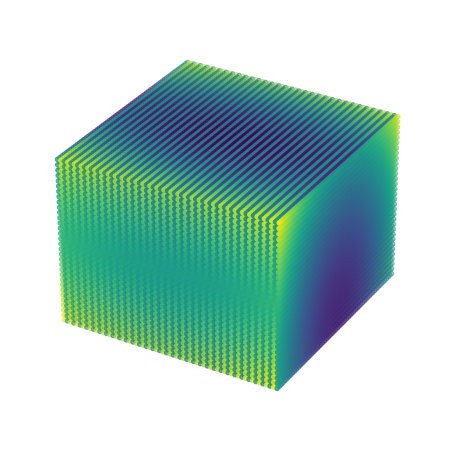

In [12]:
plot_a_3D_frame(x, 0, 0, figsize=(8, 8))

Now that we have standardized the size of our frames, we will split them to train / val /test sets, and then we'll be able to proceed with the model

In [13]:
y = np.zeros([x.shape[0], 1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=SEED)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((4, 100, 32, 64, 64),
 (4, 1),
 (2, 100, 32, 64, 64),
 (2, 1),
 (2, 100, 32, 64, 64),
 (2, 1))

# The network

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv3D, Input, MaxPool3D, Flatten
from tensorflow.keras.layers import TimeDistributed, LSTM

## Constructing a test layer

We'll start by looking at  $32 \times 64^2$ one frame at a time. The first input dimension indicates time, the next 3 are for the frame sizes, and the last one is the color channel (only 1).

In [17]:
lay_input = Input(shape=(None, 32, 64, 64, 1))

We'll construct a prototype network with an input layer, 2 image processing layers (convolutional layers), and an LSTM layer to handle time.

This network will serve as a proof of concept to test how it handles 3D video input, and to see if convolutional RNN networks give us viable results.

After doing some testing with RNNs, we'll test time handling with transformers, and we'll compare the results.

## The spacial component

This will handle the input and the convolutionl layers

In [18]:
l_a = TimeDistributed(Conv3D(16, 3))(lay_input)
l_a = TimeDistributed(Conv3D(32, 3))(l_a)
l_a = TimeDistributed(MaxPool3D(3))(l_a)

In [19]:
model = tf.keras.Model(inputs= lay_input, outputs=l_a)

In [20]:
model.summary(line_length=100)

Model: "model"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         [(None, None, 32, 64, 64, 1)]           0              
____________________________________________________________________________________________________
time_distributed (TimeDistributed)           (None, None, 30, 62, 62, 16)            448            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistributed)         (None, None, 28, 60, 60, 32)            13856          
____________________________________________________________________________________________________
time_distributed_2 (TimeDistributed)         (None, None, 9, 20, 20, 32)             0              
Total params: 14,304
Trainable params: 14,304
Non-trainable params: 0
______

## The time component
connect the convolutional prototype to a time analysis layer (for now we'll test with LSTM, and in the future we will also test transformers)

In [21]:
l_b = TimeDistributed(Flatten())(l_a)
l_b = LSTM(1024)(l_b)
l_b = Dense(256)(l_b)
l_b = Dropout(0.5)(l_b)
l_b = Dense(1)(l_b)
model2 = tf.keras.Model(inputs= lay_input, outputs=l_b)

## Final model summary

In [22]:
model2.summary(line_length=100)

Model: "model_1"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         [(None, None, 32, 64, 64, 1)]           0              
____________________________________________________________________________________________________
time_distributed (TimeDistributed)           (None, None, 30, 62, 62, 16)            448            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistributed)         (None, None, 28, 60, 60, 32)            13856          
____________________________________________________________________________________________________
time_distributed_2 (TimeDistributed)         (None, None, 9, 20, 20, 32)             0              
__________________________________________________________________________

## Training on the fabricated data

In [23]:
model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [24]:
a1 = x[0, :, :, :, :].reshape(100, 32, 64, 64, 1)

In [ ]:
history = model2.fit(x=x_train, 
                     y=y_train, 
                     batch_size=2, 
                     epochs=4, 
                     validation_data=(x_val, y_val), 
                     shuffle=True, 
                     use_multiprocessing=True)

Epoch 1/4


NameError: name 'a1' is not defined